In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from random import shuffle
import cv2 as cv
import os
import math
from random import shuffle

In [2]:
%%time

def delete_zero_files_from_list(directory):
    del_files_list = []
    for f in directory:
        if os.path.getsize(f) < 100:
            del_files_list += [f]
    
    for f in del_files_list:
        directory.remove(f)

#image_dir = '/home/alexey/programming/Convermax_projects/texture_classifiation/data/learn_data_t_f/'
#image_dir = '/home/alexey/programming/keggle_tasks/google_landmark/learn_images_data/'
image_dir = 'train_data/'
names = os.listdir(image_dir)

shuffle(names)

start_count = len(names)

start_shape = (256, 256, 3)

images_path_list = [os.path.normpath(image_dir + fname) for fname in names]
delete_zero_files_from_list(images_path_list)

print("Всего изображений:", len(images_path_list))
print("Не рассматривается изображений:", start_count - len(images_path_list))

def resize_coeff(x, new_x):
    return new_x / x

def parse_images(images_path_list):
    '''
    images_list = [cv.imread(img, 0) for img in images_path_list]    
    
    resize_images = [cv.resize(img, None, fx=resize_coeff(img.shape[1], start_shape[0]),
            fy=resize_coeff(img.shape[0], start_shape[1]), interpolation = cv.INTER_CUBIC) for img in images_list]
    
    bw = [cv.adaptiveThreshold(img,
                            255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 2)
                        for img in images_list]
    
    bw = [cv.resize(img, None, fx=resize_coeff(img.shape[1], start_shape[0]),
            fy=resize_coeff(img.shape[0], start_shape[1]), interpolation = cv.INTER_CUBIC) for img in bw]
    
    bw = np.array([cv.adaptiveThreshold(img,
                            255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 2)
                        for img in bw], dtype=np.float32)
    
    gray = np.array([img for img in resize_images], dtype=np.float32)
    
    #laplasian = np.array([cv.Laplacian(img, cv.CV_64F) for img in resize_images], dtype=np.float32)
    '''
    color = [cv.imread(img, 1) for img in images_path_list]
    color = [cv.resize(img, None, fx=resize_coeff(img.shape[1], start_shape[0]),
            fy=resize_coeff(img.shape[0], start_shape[1]), interpolation = cv.INTER_AREA) for img in color]

    return color

Всего изображений: 51548
Не рассматривается изображений: 0
CPU times: user 185 ms, sys: 91.3 ms, total: 276 ms
Wall time: 277 ms


In [3]:
batch_size = 8
latent_dim_sqrt = 16
latent_dim = latent_dim_sqrt ** 2
dropout_rate = 0.3
start_lr = 0.0001

In [16]:
import tensorflow as tf
tf.reset_default_graph()

In [4]:
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, UpSampling2D, Reshape, Flatten, BatchNormalization, Lambda
from keras.layers import LeakyReLU, Input, Dropout, Conv2DTranspose
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras import losses
from keras.models import load_model

def create_autoencoder_models():
    models = {}

    def apply_bn_and_dropout(x):
        return Dropout(0.4)(x)
    
    input_img = Input(shape=start_shape)    
    
    x = Conv2D(128,(16,16),activation='relu', padding='same')(input_img)
    x = MaxPooling2D()(x)
    x = apply_bn_and_dropout(x)
    x = Conv2D(256,(10,10),activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = apply_bn_and_dropout(x)
    x = Conv2D(256,(5,5),activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = apply_bn_and_dropout(x)
    x = Conv2D(512,(4,4),activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = apply_bn_and_dropout(x)
    x = Flatten()(x)
    
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    encoded = Reshape(((latent_dim_sqrt, latent_dim_sqrt, 1)))(l)
    #encoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    print(encoded.shape)
    
    z = Input(shape=(latent_dim_sqrt, latent_dim_sqrt, 1))    
    x = Conv2DTranspose(512,(4,4),activation='relu', padding='same')(z)
    x = UpSampling2D()(x)
    x = apply_bn_and_dropout(x)
    x = Conv2DTranspose(256,(5,5),activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = apply_bn_and_dropout(x)
    x = Conv2DTranspose(256,(10,10),activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = apply_bn_and_dropout(x)
    x = Conv2DTranspose(128,(16,16),activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = apply_bn_and_dropout(x)
    x = Conv2DTranspose(3, (16, 16), activation='sigmoid', padding='same')(x)        
    decoded = Reshape((start_shape[0], start_shape[1], 3))(x)
    
    models["encoder"] = Model(input_img, encoded, name='Encoder')
    models["decoder"] = Model(z, decoded, name='Decoder')
    models["autoencoder"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name="AUTOENCODER")
    
    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, start_shape[0]*start_shape[1]*3))
        decoded = K.reshape(decoded, shape=(batch_size, start_shape[0]*start_shape[1]*3))
        xent_loss = 3*start_shape[0]*start_shape[1]*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/start_shape[0]/start_shape[1]/3
    
    return models, vae_loss

def load_autoencoder_model(encoder_name, decoder_name, au_name):
    models, loss = create_autoencoder_models()
    models["encoder"].load_weights(encoder_name)
    models["decoder"].load_weights(decoder_name)
    #input_img = Input(batch_shape=(batch_size, start_shape[0], start_shape[1], 3))
    models["autoencoder"].load_weights(au_name)
    
    return models, loss

#models, loss = create_autoencoder_models()
models, loss = load_autoencoder_model('weights_vae_color_encoder_model_128x128_to_256.h5', 'weights_vae_color_decoder_model_256_to_128x128.h5', 'weights_vae_color_autoencoder_model_128x128_256_128x128.h5')
autoencoder = models["autoencoder"]

autoencoder.compile(optimizer=Adam(start_lr), loss=loss)

autoencoder.summary()

Using TensorFlow backend.


(8, 16, 16, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
Encoder (Model)              (None, 16, 16, 1)         74221184  
_________________________________________________________________
Decoder (Model)              (None, 256, 256, 3)       18326659  
Total params: 92,547,843
Trainable params: 92,547,843
Non-trainable params: 0
_________________________________________________________________


In [5]:
from threading import Thread, Lock
from queue import Queue

class Worker(Thread):
    """ Thread executing tasks from a given tasks queue """
    def __init__(self, tasks):
        Thread.__init__(self)
        self.tasks = tasks
        self.daemon = True
        self.start()

    def run(self):
        while True:
            func, args, kargs = self.tasks.get()
            try:
                func(*args, **kargs)
            except Exception as e:
                print(e)
            finally:
                self.tasks.task_done()


class ThreadPool:
    """ Pool of threads consuming tasks from a queue """
    def __init__(self, num_threads):
        self.tasks = Queue(num_threads)
        for _ in range(num_threads):
            Worker(self.tasks)

    def add_task(self, func, *args, **kargs):
        """ Add a task to the queue """
        self.tasks.put((func, args, kargs))

    def map(self, func, args_list):
        """ Add a list of tasks to the queue """
        for args in args_list:
            self.add_task(func, args)

    def wait_completion(self):
        """ Wait for completion of all the tasks in the queue """
        self.tasks.join()
        
        
def change_to_0_1(x):
    x = np.array(x).astype('float32') / 255.
    x = np.reshape(x, (len(x), start_shape[0], start_shape[1], 3))
    return x

def norm_size(x, bs):
    return x[0:(len(x) - len(x) % bs)]



gpu_model_lock = Lock()



def nn_fit(model, X, validation_size, batch_size):
    x_train = change_to_0_1(parse_images(X))

    x_val = norm_size(x_train[len(x_train) - validation_size:len(x_train)], batch_size)
    x_tr = norm_size(x_train[0:len(x_train) - validation_size], batch_size)
    
    gpu_model_lock.acquire()
    model.fit(x_tr, x_tr, shuffle=True, batch_size=batch_size, validation_data=(x_val, x_val))
    gpu_model_lock.release()
    
    del x_train
    del x_val
    del x_tr

    
    
def parting_predict_keras_model(images_names_list, model, queue_length, images_in_part, epochs, batch_size=batch_size):  
    print('#######################################################################')

    N = len(images_names_list) // images_in_part
    if len(images_names_list) % images_in_part != 0:
        N += 1

    pool = ThreadPool(queue_length)
        
    for e in range(epochs):
        nn_fit(model, images_names_list[0:100], 20, batch_size)
        for i in range(N):
            left = i*images_in_part
            right = (i+1)*images_in_part
            if right > len(images_names_list):
                right = len(images_names_list)
                
            print("Шаг обучения на элементах:", left, ":", right, "из", len(images_names_list))
            print("Количество элементов для текущего шага обучения:", len(images_names_list),"эпоха",
                  str(e + 1) + '/' + str(epochs))
            
            pool.add_task(nn_fit, model, images_names_list[left:right], 20, batch_size)
            
            print("Обучение данного набора занесено в очередь")
            print('#######################################################################')
    
    pool.wait_completion()
    
    print("Обучение нейронной сети успешно завершено!")

In [6]:
%%time
E = 3
for i in range(E):
    print('Epoch:', i + 1, 'from', E)
    
    nn_fit(autoencoder, images_path_list[0:100], 20, batch_size)
    parting_predict_keras_model(images_path_list, autoencoder, 5, 200, 1, batch_size)
    nn_fit(autoencoder, images_path_list[0:100], 20, batch_size)
    
    gpu_model_lock.acquire()
    models["encoder"].save_weights('weights_vae_color_encoder_model_128x128_to_256.h5')
    models["decoder"].save_weights('weights_vae_color_decoder_model_256_to_128x128.h5')
    models["autoencoder"].save_weights('weights_vae_color_autoencoder_model_128x128_256_128x128.h5')
    gpu_model_lock.release()

Epoch: 1 from 3
Train on 80 samples, validate on 16 samples
Epoch 1/1
80/80 [==============================] - 19s 236ms/step - loss: 0.2415 - val_loss: 0.2794
#######################################################################
Train on 80 samples, validate on 16 samples
Epoch 1/1
80/80 [==============================] - 11s 138ms/step - loss: 0.2393 - val_loss: 0.2805
Шаг обучения на элементах: 0 : 200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
Обучение данного набора занесено в очередь
#######################################################################
Шаг обучения на элементах: 200 : 400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
Обучение данного набора занесено в очередь
#######################################################################
Шаг обучения на элементах: 400 : 600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
Обучение данного набора занесено в очередь
####################

176/176 [==============================] - 23s 133ms/step - loss: 0.2256 - val_loss: 0.3020
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 5200 : 5400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 23s 133ms/step - loss: 0.2168 - val_loss: 0.3092
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples

Epoch 1/1#######################################################################

Шаг обучения на элементах: 5400 : 5600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 23s 133ms/step - loss: 0.2223 - val_loss: 0.2837
Обучение данного набора занесено в очередь
#######################################################################
Шаг обучения на элементах: 5600 : 5800 из 5

176/176 [==============================] - 24s 135ms/step - loss: 0.2229 - val_loss: 0.2767
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

Epoch 1/1#######################################################################

Шаг обучения на элементах: 9600 : 9800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2304 - val_loss: 0.3066
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 9800 : 10000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2270 - val_loss: 0.2905
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#####################################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2289 - val_loss: 0.2981
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 14000 : 14200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 23s 133ms/step - loss: 0.2201 - val_loss: 0.2807
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 14200 : 14400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2381 - val_loss: 0.3014
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2257 - val_loss: 0.2598
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 18400 : 18600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2278 - val_loss: 0.2820
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 18600 : 18800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2222 - val_loss: 0.2859
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2281 - val_loss: 0.2955
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 22800 : 23000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2216 - val_loss: 0.2888
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 23000 : 23200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2391 - val_loss: 0.3055
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
###################################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2227 - val_loss: 0.2814
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 27200 : 27400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2205 - val_loss: 0.2889
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 27400 : 27600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2237 - val_loss: 0.2705
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2305 - val_loss: 0.3073
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 31600 : 31800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2270 - val_loss: 0.2593
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 31800 : 32000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2172 - val_loss: 0.2726
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples

##################################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2202 - val_loss: 0.2947
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 36000 : 36200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2355 - val_loss: 0.2691
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 36200 : 36400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2284 - val_loss: 0.2995
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
###################################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2291 - val_loss: 0.2979
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 40400 : 40600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2352 - val_loss: 0.3002
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 40600 : 40800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2267 - val_loss: 0.2952
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2284 - val_loss: 0.2889
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 44800 : 45000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2185 - val_loss: 0.2740
Обучение данного набора занесено в очередь
Train on 176 samples, validate on 16 samples#######################################################################

Epoch 1/1Шаг обучения на элементах:
 45000 : 45200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2125 - val_loss: 0.2977
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
###################################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2300 - val_loss: 0.2908
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 49200 : 49400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2282 - val_loss: 0.2771
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 49400 : 49600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2259 - val_loss: 0.2748
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

Train on 176 samples, validate on 16 samples
Epoch 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2207 - val_loss: 0.2843
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 2200 : 2400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2399 - val_loss: 0.2756
Обучение данного набора занесено в очередь
#######################################################################Train on 176 samples, validate on 16 samples

Шаг обучения на элементах:Epoch 1/1
 2400 : 2600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 23s 133ms/step - loss: 0.2242 - val_loss: 0.2958
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#####

176/176 [==============================] - 24s 135ms/step - loss: 0.2246 - val_loss: 0.3079
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 6600 : 6800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2268 - val_loss: 0.2832
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 6800 : 7000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2188 - val_loss: 0.2848
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples

Epoch 1/1#############################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2166 - val_loss: 0.2859
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 11000 : 11200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 23s 134ms/step - loss: 0.2292 - val_loss: 0.2947
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 11200 : 11400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2210 - val_loss: 0.2903
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2252 - val_loss: 0.2953
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 15400 : 15600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2366 - val_loss: 0.2944
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 15600 : 15800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2191 - val_loss: 0.2751
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

##################################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2313 - val_loss: 0.2918
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 19800 : 20000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2237 - val_loss: 0.2965
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 20000 : 20200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2162 - val_loss: 0.2705
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
###################################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2154 - val_loss: 0.2935
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

Epoch 1/1#######################################################################

Шаг обучения на элементах: 24200 : 24400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2405 - val_loss: 0.2718
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 24400 : 24600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2312 - val_loss: 0.3116
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
###################################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2217 - val_loss: 0.2780
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 28600 : 28800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2275 - val_loss: 0.2909
Обучение данного набора занесено в очередь
Train on 176 samples, validate on 16 samples#######################################################################

Epoch 1/1Шаг обучения на элементах:
 28800 : 29000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2317 - val_loss: 0.2792
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2150 - val_loss: 0.2945
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 33000 : 33200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2171 - val_loss: 0.2862
Обучение данного набора занесено в очередь
#######################################################################Train on 176 samples, validate on 16 samples

Epoch 1/1Шаг обучения на элементах:
 33200 : 33400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2234 - val_loss: 0.2884
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
###################################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2200 - val_loss: 0.2734
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 37400 : 37600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2276 - val_loss: 0.2813
Обучение данного набора занесено в очередь
Train on 176 samples, validate on 16 samples#######################################################################

Epoch 1/1Шаг обучения на элементах:
 37600 : 37800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2208 - val_loss: 0.2949
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
###################################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2240 - val_loss: 0.2896
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 41800 : 42000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 23s 133ms/step - loss: 0.2359 - val_loss: 0.2840
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 42000 : 42200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2276 - val_loss: 0.2883
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2306 - val_loss: 0.2910
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 46200 : 46400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 23s 133ms/step - loss: 0.2212 - val_loss: 0.2923
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 46400 : 46600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2267 - val_loss: 0.2869
Обучение данного набора занесено в очередь
#######################################################################
Шаг обучения на элементах: 46600 : 4680

176/176 [==============================] - 24s 135ms/step - loss: 0.2332 - val_loss: 0.3079
Train on 176 samples, validate on 16 samples
Epoch 1/1
Обучение данного набора занесено в очередь
#######################################################################
Шаг обучения на элементах: 50600 : 50800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2326 - val_loss: 0.2841
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples

Epoch 1/1#######################################################################

Шаг обучения на элементах: 50800 : 51000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2343 - val_loss: 0.2683
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2179 - val_loss: 0.2839
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 3200 : 3400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2261 - val_loss: 0.2876
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 3400 : 3600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 23s 134ms/step - loss: 0.2076 - val_loss: 0.2722
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

############################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2124 - val_loss: 0.2783
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 7600 : 7800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2263 - val_loss: 0.2866
Обучение данного набора занесено в очередь
Train on 176 samples, validate on 16 samples#######################################################################

Epoch 1/1Шаг обучения на элементах:
 7800 : 8000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2346 - val_loss: 0.2821
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

############################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2316 - val_loss: 0.2743
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 12000 : 12200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2270 - val_loss: 0.2876
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples

Epoch 1/1#######################################################################

Шаг обучения на элементах: 12200 : 12400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2292 - val_loss: 0.2895
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2373 - val_loss: 0.3070
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 16400 : 16600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2192 - val_loss: 0.2940
Обучение данного набора занесено в очередь
#######################################################################
Train on 176 samples, validate on 16 samplesШаг обучения на элементах:
 Epoch 1/116600
 : 16800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 23s 133ms/step - loss: 0.2192 - val_loss: 0.2798
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2258 - val_loss: 0.2729
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 20800 : 21000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2269 - val_loss: 0.2858
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

#######################################################################Epoch 1/1

Шаг обучения на элементах: 21000 : 21200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2233 - val_loss: 0.2710
Train on 176 samples, validate on 16 samples
Обучение данного набора занесено в очередьEpoch 1/1

########################################################

176/176 [==============================] - 23s 133ms/step - loss: 0.2355 - val_loss: 0.2920
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 25200 : 25400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2373 - val_loss: 0.2798
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples

#######################################################################Epoch 1/1

Шаг обучения на элементах: 25400 : 25600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2279 - val_loss: 0.2728
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2308 - val_loss: 0.2735
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 29600 : 29800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2271 - val_loss: 0.2592
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
#######################################################################
Шаг обучения на элементах: 29800 : 30000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1

Epoch 1/1
176/176 [==============================] - 23s 133ms/step - loss: 0.2132 - val_loss: 0.2924
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2264 - val_loss: 0.2865
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 34000 : 34200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2367 - val_loss: 0.3009
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
#######################################################################

Epoch 1/1Шаг обучения на элементах:
 34200 : 34400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2235 - val_loss: 0.2694
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
Epoch 1/1

########################################################

176/176 [==============================] - 24s 134ms/step - loss: 0.2330 - val_loss: 0.2887
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples

Epoch 1/1#######################################################################

Шаг обучения на элементах: 38400 : 38600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2216 - val_loss: 0.2873
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 38600 : 38800 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2300 - val_loss: 0.2845
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2081 - val_loss: 0.2846
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
Шаг обучения на элементах: 42800 : 43000 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2232 - val_loss: 0.2928
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

Epoch 1/1#######################################################################

Шаг обучения на элементах: 43000 : 43200 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 23s 133ms/step - loss: 0.2309 - val_loss: 0.2644
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples
Epoch 1/1

########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2380 - val_loss: 0.2907
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь

Epoch 1/1#######################################################################
Шаг обучения на элементах:
 47200 : 47400 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2323 - val_loss: 0.2989
Обучение данного набора занесено в очередь
#######################################################################Train on 176 samples, validate on 16 samples

Шаг обучения на элементах:Epoch 1/1 
47400 : 47600 из 51548
Количество элементов для текущего шага обучения: 51548 эпоха 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2223 - val_loss: 0.2875
Обучение данного набора занесено в очередьTrain on 176 samples, validate on 16 samples

Epoch 1/1#########################################################

176/176 [==============================] - 24s 135ms/step - loss: 0.2210 - val_loss: 0.2938
Train on 176 samples, validate on 16 samplesОбучение данного набора занесено в очередь
Epoch 1/1

#######################################################################
176/176 [==============================] - 24s 134ms/step - loss: 0.2220 - val_loss: 0.2881
Train on 176 samples, validate on 16 samples
Epoch 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2201 - val_loss: 0.2731
Train on 176 samples, validate on 16 samples
Epoch 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2275 - val_loss: 0.2897
Train on 176 samples, validate on 16 samples
Epoch 1/1
176/176 [==============================] - 24s 135ms/step - loss: 0.2315 - val_loss: 0.2687
Train on 176 samples, validate on 16 samples
Epoch 1/1
176/176 [==============================] - 24s 134ms/step - loss: 0.2335 - val_loss: 0.2913
Train on 176 samples, validate on 16 samples
Epoch 1/1
176

In [7]:
for i in range(1):
    print(i)
    nn_fit(autoencoder, images_path_list[0:100], 20, batch_size)

0
Train on 80 samples, validate on 16 samples
Epoch 1/1
80/80 [==============================] - 11s 142ms/step - loss: 0.2372 - val_loss: 0.2885


In [8]:
models["encoder"].save_weights('weights_vae_color_encoder_model_128x128_to_256.h5')
models["decoder"].save_weights('weights_vae_color_decoder_model_256_to_128x128.h5')
models["autoencoder"].save_weights('weights_vae_color_autoencoder_model_128x128_256_128x128.h5')

In [6]:
#ЗАЮЗАТЬ ТЕМУ!
print_arr = []
images_path_list1 = []

def norm(x1, x2):
    res = 0.0
    for i in range(0, len(x1)):
        res += (x1[i] - x2[i]) ** 2
    return math.sqrt(res)

def get_distance(a, b):
    ind1 = images_path_list1.index(os.path.normpath(image_dir + a))
    ind2 = images_path_list1.index(os.path.normpath(image_dir + b))
    return norm(encoded_images[ind1], encoded_images[ind2])

def get_distance_from_tsne(a, b):
    ind1 = images_path_list1.index(os.path.normpath(image_dir + a))
    ind2 = images_path_list1.index(os.path.normpath(image_dir + b))
    return norm(p_field[ind1], p_field[ind2])

def get_distance_from_data(d, iname):
    ind = images_path_list1.index(os.path.normpath(image_dir + iname))
    return norm(d, encoded_images[ind])

def print_image(img, title='Image', scale=1, norm_flag=True, kernel=False):    
    plt.figure(figsize=(10, 10))
    
    if norm_flag:
        img1 = img.astype('float32') / 255.
    else:
        img1 = img
    
    ax = plt.subplot(int(scale), 1, 1)
    
    if not kernel:
        plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
    else:
        plt.imshow(img1)
        plt.gray()
        
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(title)
    
    plt.show()

def print_image_encoding(img, print_decoder=True, print_wb=True):
    ind = images_path_list1.index(os.path.normpath(image_dir + img))
    
    plt.figure(figsize=(20, 10))
    
    ax = plt.subplot(2, 1, 1)
    plt.imshow(cv.cvtColor(print_arr[ind].reshape(start_shape), cv.COLOR_BGR2RGB))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(img)
    
    if print_decoder:
        ax = plt.subplot(2, 1, 2)
        plt.imshow(cv.cvtColor(decoded_images[ind].reshape(start_shape), cv.COLOR_BGR2RGB))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def print_image_encoding_from_data(data, print_decoder=True):
    
    plt.figure(figsize=(20, 10))
    
    ax = plt.subplot(2, 1, 1)
    plt.imshow(cv.cvtColor(data.reshape(start_shape), cv.COLOR_BGR2RGB))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    batch_vector = [data]*batch_size
    batch_vector = np.resize(batch_vector, (batch_size, start_shape[0], start_shape[1], 3))
    var_image = models["autoencoder"].predict(batch_vector)[0]
    
    if print_decoder:
        ax = plt.subplot(2, 1, 2)
        plt.imshow(cv.cvtColor(var_image.reshape(start_shape), cv.COLOR_BGR2RGB))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def print_image_from_array(img, arr):
    ind = images_path_list1.index(os.path.normpath(image_dir + img))
    
    plt.figure(figsize=(20, 10))
    
    ax = plt.subplot(2, 1, 1)
    plt.imshow(cv.cvtColor(arr[ind].reshape(start_shape), cv.COLOR_BGR2RGB))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(img)
    plt.show()
    
def print_original_image(img, scale=1):
    ind = images_path_list1.index(os.path.normpath(image_dir + img))
    image = cv.imread(images_path_list[ind], 0)
    print_image(image, img, scale)
    
def print_kernel(img):
    ind = images_path_list1.index(os.path.normpath(image_dir + img))
    kernel = encoded_images[ind]
    kernel = np.reshape(kernel, (latent_dim_sqrt, latent_dim_sqrt))
    print_image(kernel, img, 3, False, True)
    
def print_kernel_from_data(data):
    batch_vector = [data]*batch_size
    batch_vector = np.resize(batch_vector, (batch_size, start_shape[0], start_shape[1], 3))
    encoded_data = models["encoder"].predict(batch_vector)[0]
    encoded_data = np.reshape(encoded_data, (latent_dim_sqrt, latent_dim_sqrt))
    print_image(encoded_data, 'kernel', 3, False, True)
    
def SortByKernel(x):
    return x[1];

def get_k_simple(img, k, d_func=get_distance):
    images_pair = [(i, d_func(img, i)) for i in names[0:len(encoded_images)]]
    images_pair.sort(key=SortByKernel)
    return [i[0] for i in images_pair[0:k]]

def get_k_simple_from_data(d, k):
    images_pair = [(i, get_distance_from_data(d, i)) for i in names[0:len(encoded_images)]]
    images_pair.sort(key=SortByKernel)
    return [i[0] for i in images_pair[0:k]]

def name_last_parse(S):
    return S[S.rindex('/') + 1:len(S)]

def full_view_by_image_name(iname, view_encoding=True, view_kernel=True):
    data = change_to_0_1(parse_images([iname]))[0]
    print_image_encoding_from_data(data, view_encoding)
    
    if view_kernel:
        print_kernel_from_data(data)
    
def get_kernel_by_image_name(iname):
    batch_vector = [change_to_0_1(parse_images([iname]))[0]]*batch_size
    batch_vector = np.resize(batch_vector, (batch_size, start_shape[0], start_shape[1], 3))
    encoded_data = models["encoder"].predict(batch_vector)[0]
    return np.reshape(encoded_data, (latent_dim_sqrt, latent_dim_sqrt))

def get_kernel_distance(im1, im2):
    return norm(get_kernel_by_image_name(im1).flatten(), get_kernel_by_image_name(im2).flatten())

def get_k_simple_to_image_by_images_names_list(iname, inames_list, k):
    images_pair = [(i, get_kernel_distance(iname, i)) for i in inames_list]
    images_pair.sort(key=SortByKernel)
    return [i[0] for i in images_pair[0:k]]

In [7]:
#del images_path_list1
#del print_arr

images_path_list1 = images_path_list[1000:1100]
#print_arr = change_to_0_1(parse_images(images_path_list1))

#encoded_images = models["encoder"].predict(print_arr, batch_size=batch_size)
#decoded_images = autoencoder.predict(print_arr, batch_size=batch_size)
    
#encoded_images = np.reshape(encoded_images, (len(encoded_images), latent_dim))

In [11]:
import json

def ParseData(data_file):
    ann = {}
    if 'train' in data_file or 'validation' in data_file:
        _ann = json.load(open(data_file))['annotations']
        for a in _ann:
            ann[a['image_id']] = a['label_id']

    key_url_list = []
    j = json.load(open(data_file))
    images = j['images']
    for item in images:
        assert len(item['url']) == 1
        url = item['url'][0]
        id_ = item['image_id']
        if id_ in ann:
            id_ = "{}_{}".format(id_, ann[id_])
        key_url_list.append((id_, url))
    return key_url_list

def get_image_label_from_json_by_url(json_data, image_url):
    res_label= -1
    for line in json_data['images']:
        if line['url'][0] == image_url:
            res_id = line['image_id']
            res_label = json_data['annotations'][res_id - 1]['label_id']
            break
    return res_label


json_filename = os.path.normpath('train.json')
json_train = json.load(open(json_filename))
second_indexes_json = ParseData(json_filename)

def get_image_label_from_json(json_data, image_name, second_indexes_json=second_indexes_json):
    res_label = -1
    for (name, url) in second_indexes_json:
        if name + '.jpg' == image_name:
            res_label = get_image_label_from_json_by_url(json_data, url)
    return res_label

def get_labels_list(json_data, images_list):
    return [get_image_label_from_json(json_data, name_last_parse(im)) for im in images_list]

In [12]:
%%time
images_labels = get_labels_list(json_train, images_path_list1)

CPU times: user 2.48 s, sys: 18.8 ms, total: 2.5 s
Wall time: 2.51 s


In [15]:
images_labels[0:10]

[67, 37, 68, 117, 13, 55, 120, 59, 5, 79]

In [65]:
print(name_last_parse(images_path_list1[4]))

31442_127.jpg


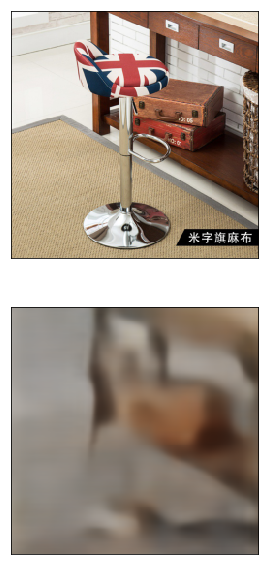

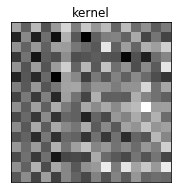

In [66]:
ind = 15
imname = images_path_list1[ind]
full_view_by_image_name(imname)

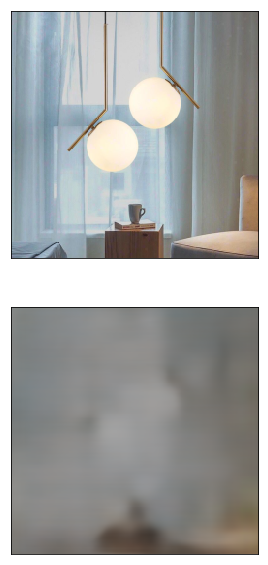

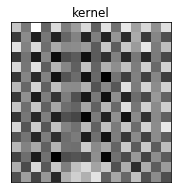

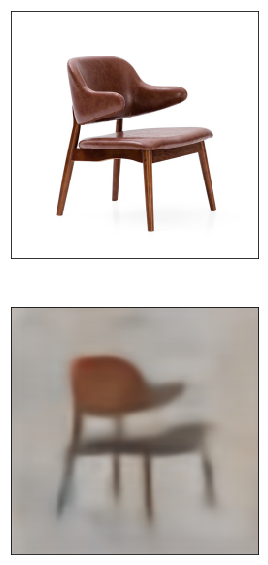

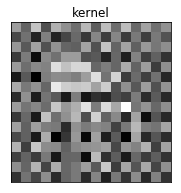

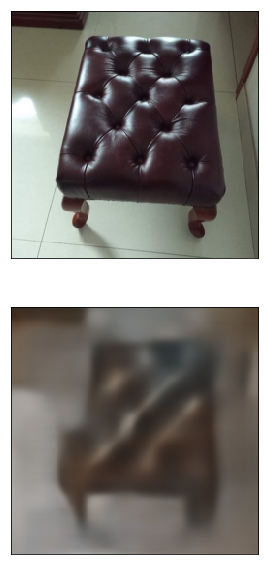

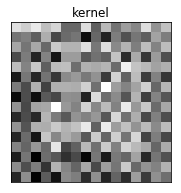

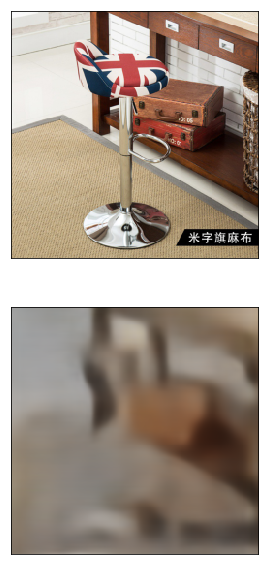

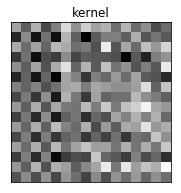

In [67]:
for ind in [0, 5, 10, 15]:
    imname = images_path_list1[ind]
    full_view_by_image_name(imname)

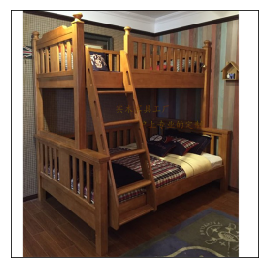

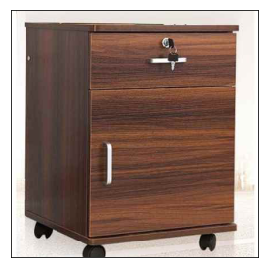

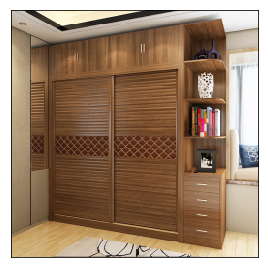

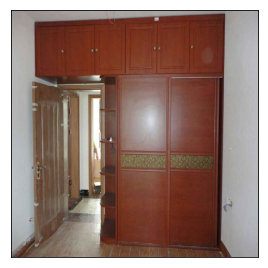

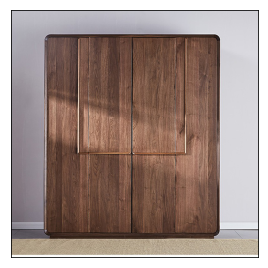

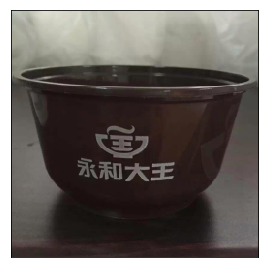

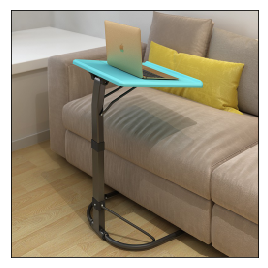

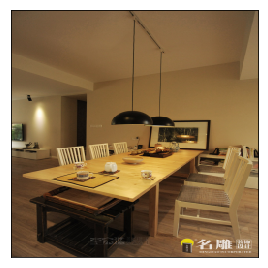

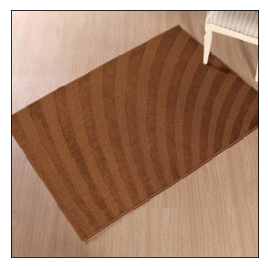

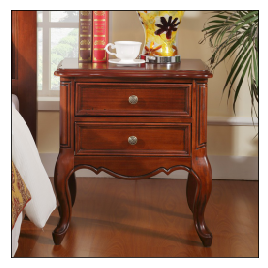

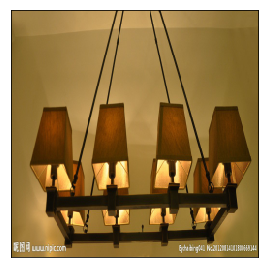

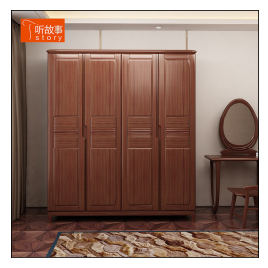

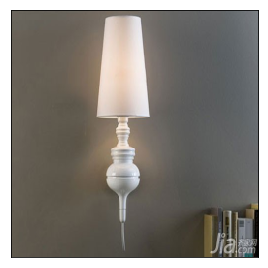

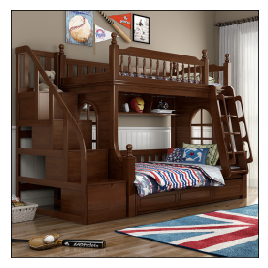

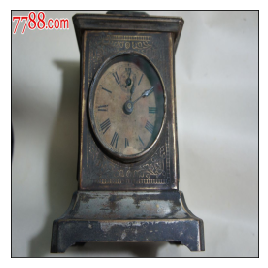

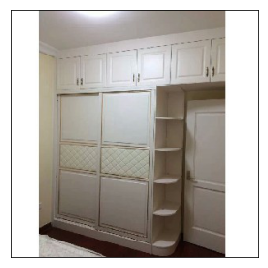

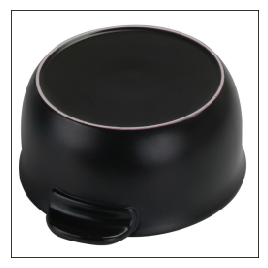

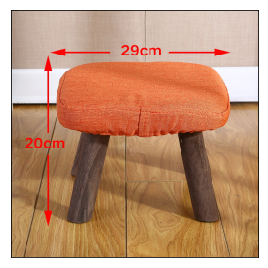

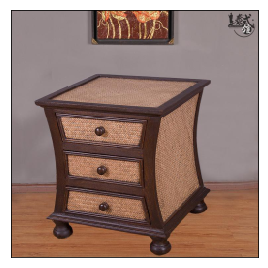

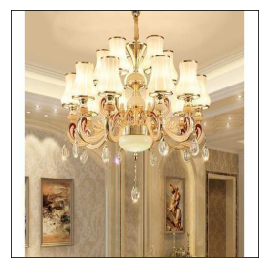

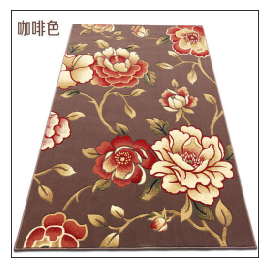

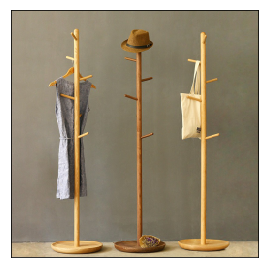

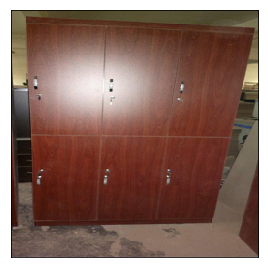

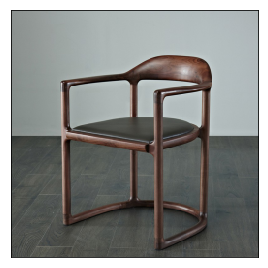

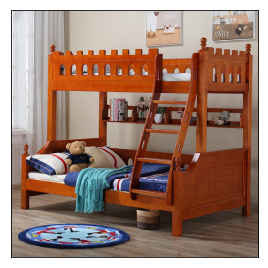

In [33]:
for e in get_k_simple_to_image_by_images_names_list(images_path_list1[15], images_path_list1, 25):
    full_view_by_image_name(e, False, False)

In [1]:
#X = [get_kernel_by_image_name(img) for img in images_path_list1]

In [69]:
def normal_array(x, max_elem=1):
    for i in range(len(x)):
        if x[i] == float('Inf'):
            x[i] = max_elem
        if x[i] == float('NaN'):
            x[i] = 0.0
    return x

X = np.reshape(X, (len(X), latent_dim_sqrt*latent_dim_sqrt))
#X = np.array([normal_array(i) for i in X], dtype=np.float32)
X.shape

(100, 256)

In [92]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)

p_field = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 3.279838
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.354126
[t-SNE] Error after 1000 iterations: 0.565122


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
p_field = pca.fit_transform(X)

In [4]:
#plt.figure(figsize=(12,10))
#plt.scatter(p_field[:, 0], p_field[:, 1], c=images_labels,#color='blue', 
#            edgecolor='none', alpha=0.7, s=40,
#            cmap=plt.cm.get_cmap('nipy_spectral', 10))
#plt.colorbar()
#plt.title('images projection')

#print(p_field.shape)
#print(tsne.get_params(True))

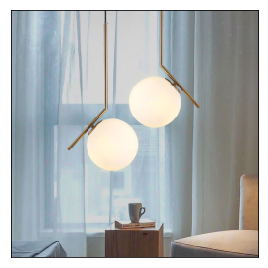

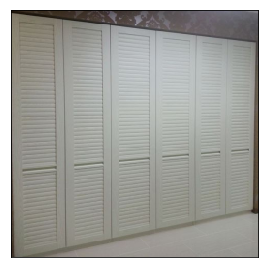

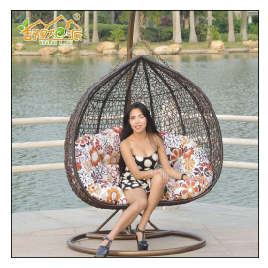

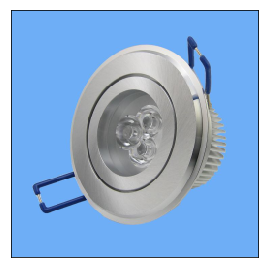

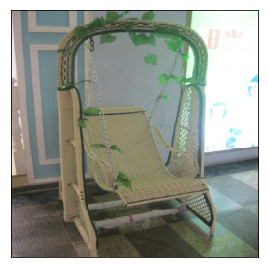

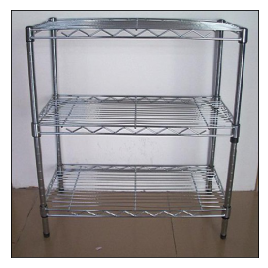

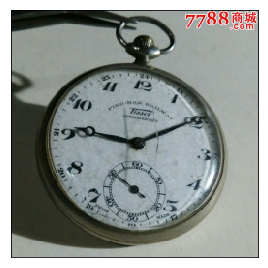

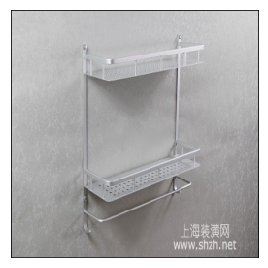

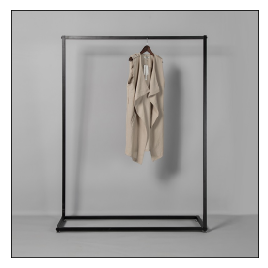

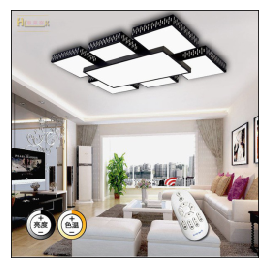

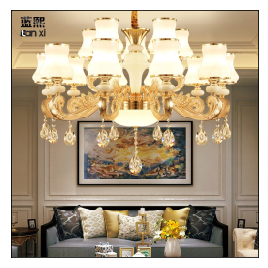

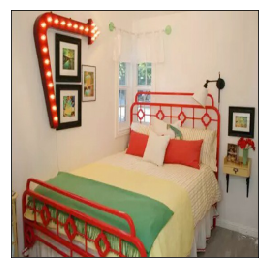

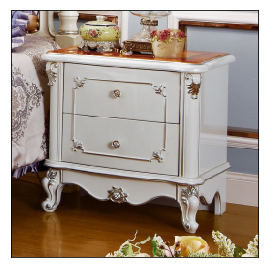

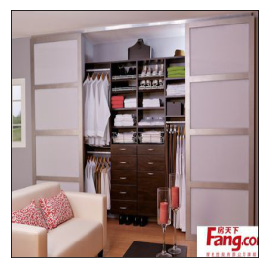

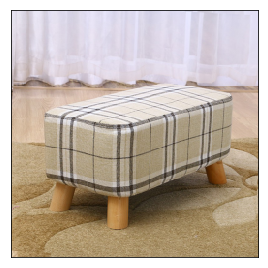

In [72]:
ind = 0
L2_list = [[i, norm(p_field[ind], p_field[i])] for i in range(len(p_field))]

L2_list.sort(key=SortByKernel)

for i in range(15):
    full_view_by_image_name(images_path_list1[L2_list[i][0]], False, False)

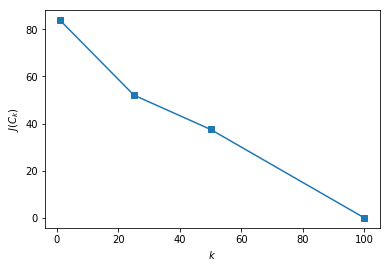

In [91]:
from sklearn.cluster import KMeans

N = [1, 25, 50, 100]
inertia = []
for k in N:
    kmeans = KMeans(n_clusters=k, random_state=1, n_jobs=4).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(N, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [21]:
N = 128
kmeans = KMeans(n_clusters=N, random_state=1, n_jobs=4).fit(X)
Y = kmeans.predict(X)

In [74]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(X, images_labels)
Y = clf.predict(X)

In [75]:
def show_class(ks):
    for i in range(len(Y)):
        if Y[i] == ks:
            full_view_by_image_name(images_path_list1[i], False, False)

In [76]:
show_class(134)

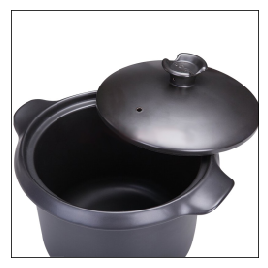

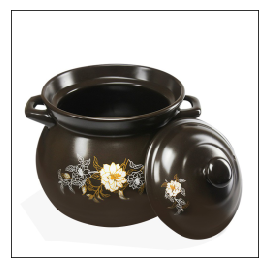

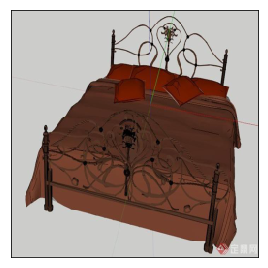

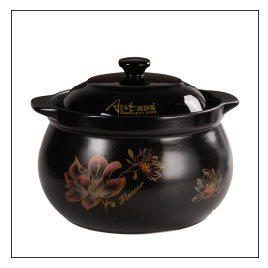

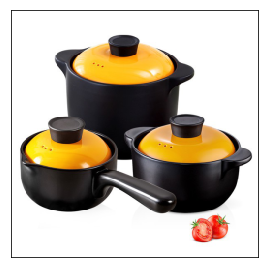

In [111]:
show_class(131)

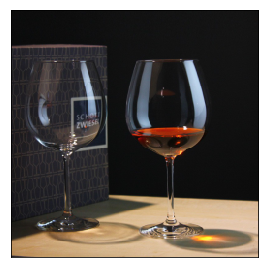

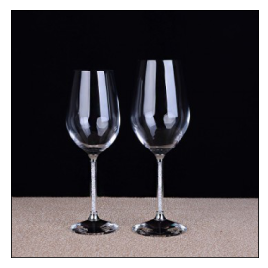

In [114]:
show_class(74)

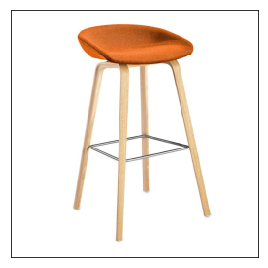

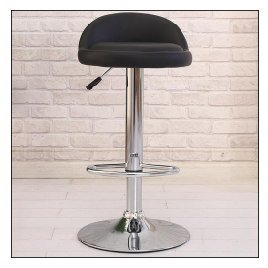

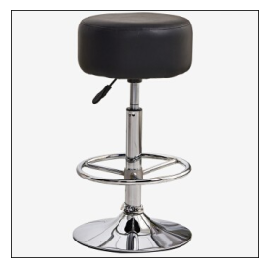

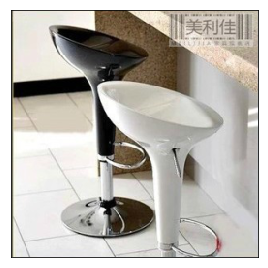

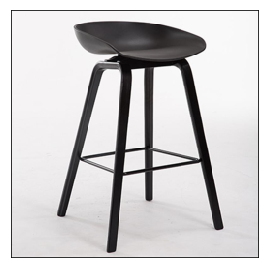

In [122]:
show_class(9)

In [79]:
N = 128
num_Y = [0]*N
for y in Y:
    num_Y[y] += 1
    
for i in range(N):
    print(i,':',num_Y[i])

0 : 0
1 : 0
2 : 0
3 : 0
4 : 4
5 : 4
6 : 0
7 : 0
8 : 0
9 : 1
10 : 0
11 : 0
12 : 0
13 : 1
14 : 0
15 : 1
16 : 0
17 : 0
18 : 0
19 : 0
20 : 0
21 : 0
22 : 0
23 : 0
24 : 5
25 : 0
26 : 0
27 : 0
28 : 3
29 : 0
30 : 0
31 : 4
32 : 3
33 : 0
34 : 0
35 : 0
36 : 0
37 : 6
38 : 0
39 : 2
40 : 0
41 : 0
42 : 0
43 : 0
44 : 0
45 : 0
46 : 0
47 : 0
48 : 1
49 : 0
50 : 3
51 : 0
52 : 0
53 : 0
54 : 0
55 : 5
56 : 0
57 : 0
58 : 0
59 : 2
60 : 0
61 : 0
62 : 1
63 : 0
64 : 1
65 : 0
66 : 0
67 : 0
68 : 5
69 : 0
70 : 0
71 : 0
72 : 0
73 : 0
74 : 1
75 : 0
76 : 0
77 : 3
78 : 0
79 : 3
80 : 0
81 : 0
82 : 0
83 : 0
84 : 0
85 : 0
86 : 0
87 : 0
88 : 0
89 : 6
90 : 0
91 : 0
92 : 0
93 : 0
94 : 0
95 : 0
96 : 0
97 : 1
98 : 0
99 : 5
100 : 0
101 : 1
102 : 0
103 : 0
104 : 7
105 : 0
106 : 2
107 : 0
108 : 0
109 : 0
110 : 2
111 : 0
112 : 0
113 : 0
114 : 0
115 : 0
116 : 0
117 : 2
118 : 0
119 : 0
120 : 8
121 : 0
122 : 4
123 : 0
124 : 0
125 : 0
126 : 0
127 : 3


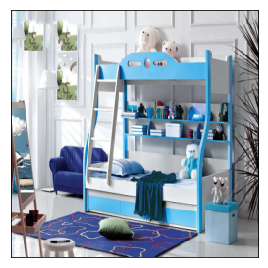

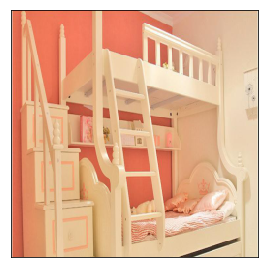

In [102]:
show_class(117)